In [1]:
import model
import baseline_model as baseline
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data preparation

In [4]:
no_of_sensor = 8

In [17]:
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_train:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_array = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_array = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_array.shape)
print(full_field_data_whole_array.shape)

# Normalization
min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)
full_field_data_whole_array_norm = (full_field_data_whole_array - min_val)/(max_val - min_val)
sensor_data_whole_array_norm = (sensor_data_whole_array - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_array_norm), np.amax(full_field_data_whole_array_norm))
print("Check sens data: ", np.amin(sensor_data_whole_array_norm), np.amax(sensor_data_whole_array_norm))


(429, 8)
(429, 128, 256, 1)
Check field data:  0.0 1.0
Check sens data:  0.013270650800024661 0.766168138177504


In [18]:
# Prepare field data

Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_test:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_test = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_test.shape)
print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = (sensor_data_whole_test - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

(156, 8)
(156, 128, 256, 1)
Check field data:  0.0 0.9929987273789493
Check sens data:  0.04263783972866182 0.7515328263773662


## Load model

### FLRNet

In [19]:
tf.keras.backend.clear_session()
flow_recon_net = model.FLRNet(n_sensor = no_of_sensor)
flow_recon_net.encoder.load_weights('encoder_8_cir.h5')
flow_recon_net.decoder.load_weights('decoder_8_cir.h5')
flow_recon_net.sens_mapping.load_weights('mapping_8_cir.h5')

### Other baselines

In [26]:
mlp_recon = baseline.MLP_CNN(no_of_sensor = no_of_sensor)
mlp_recon.load_weights('mlp_cnn_8_ran.h5')

### Prediction

In [27]:
# Save model weight
# Reconstruction
gt_data = []
reconstruction_sens = []
reconstruction_mlp_cnn = []
for case_idx in range(4):
    gt_data.append(full_field_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:,:,:])

    ## FLRNet
    _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
    reconstruction_sens_iter = flow_recon_net.decoder(z_sens).numpy()
    reconstruction_sens.append(reconstruction_sens_iter)

    reconstruction_mlp_cnn_iter = mlp_recon(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:]).numpy()
    reconstruction_mlp_cnn.append(reconstruction_mlp_cnn_iter)

# ## MLP - L1
# _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
# reconstruction_sens = flow_recon_net.decoder(z_sens).numpy()

# ## MLP - L2
# _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
# reconstruction_sens = flow_recon_net.decoder(z_sens).numpy()

# ## MLP - PINN
# _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
# reconstruction_sens = flow_recon_net.decoder(z_sens).numpy()

# ## MLP + CNN
# _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
# reconstruction_sens = flow_recon_net.decoder(z_sens).numpy()

In [28]:
gt_data = np.array(gt_data)
reconstruction_sens = np.array(reconstruction_sens)
reconstruction_mlp_cnn = np.array(reconstruction_mlp_cnn)

In [29]:
gt_data.shape

(4, 39, 128, 256, 1)

In [30]:
mae_vae = np.mean(np.abs(gt_data-reconstruction_sens), axis = (0,1,2,3))
mae_mlp_cnn= np.mean(np.abs(gt_data-reconstruction_mlp_cnn), axis = (0,1,2,3))

In [31]:
mae_vae

array([0.02064313])

In [32]:
mae_mlp_cnn

array([0.01169692])

In [ ]:
tf.reduce_sum(tf.abs(gt_data-

## Validation

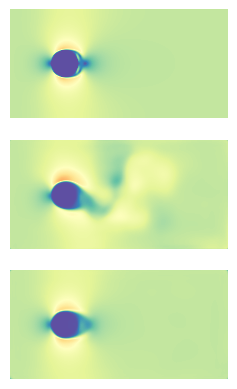

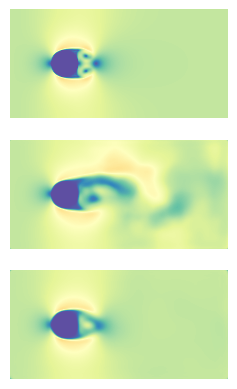

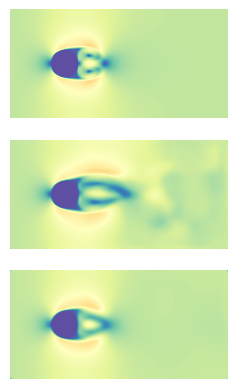

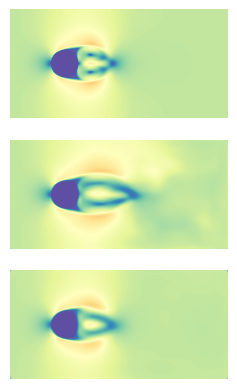

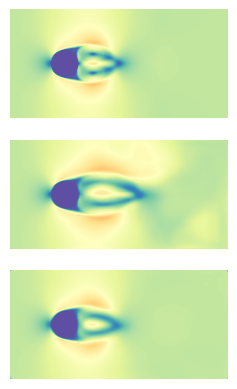

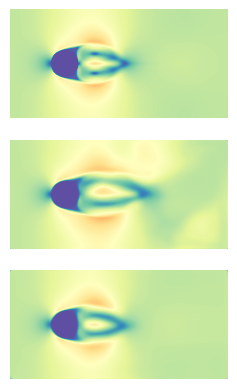

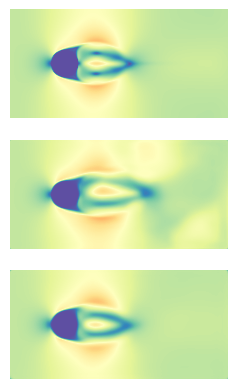

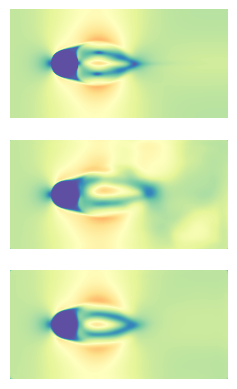

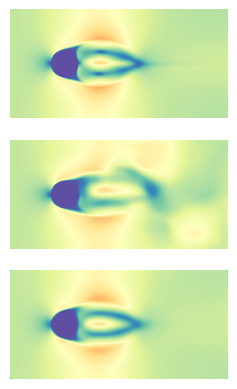

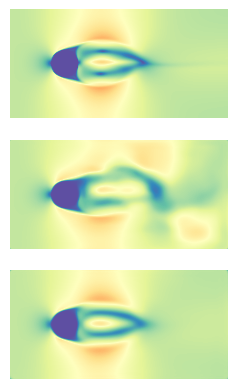

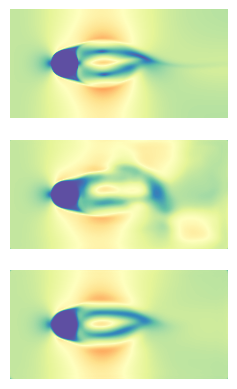

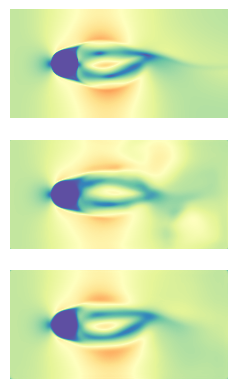

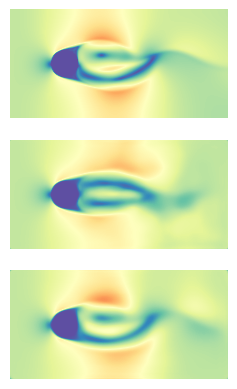

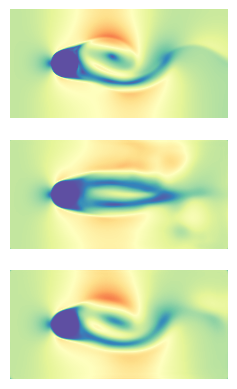

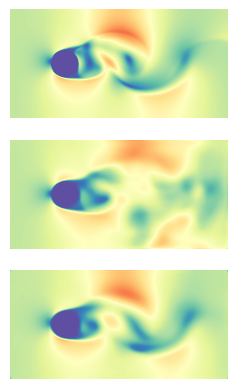

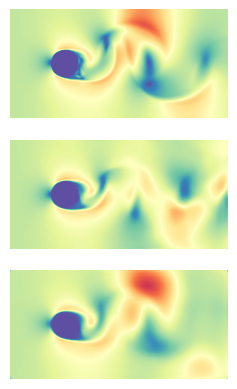

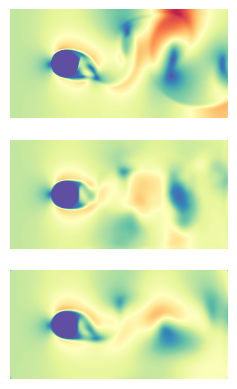

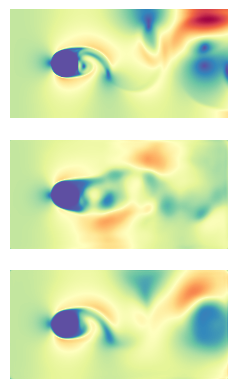

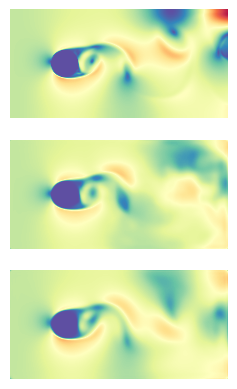

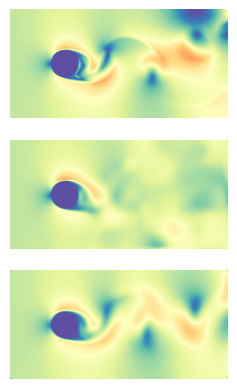

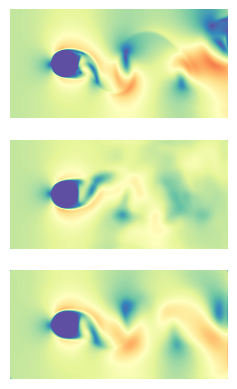

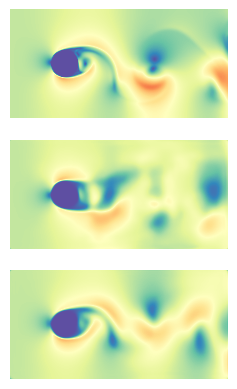

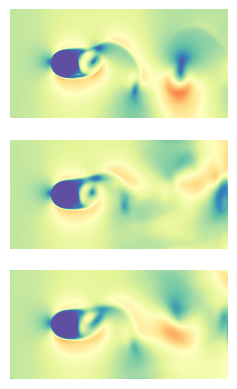

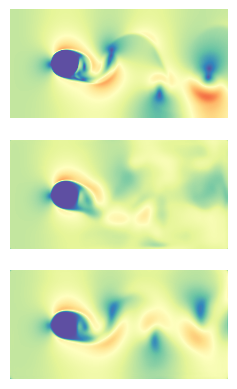

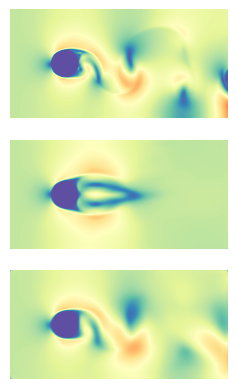

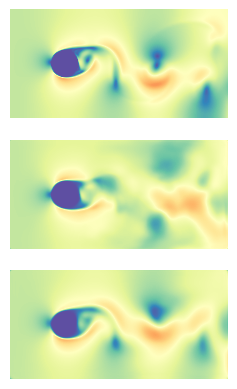

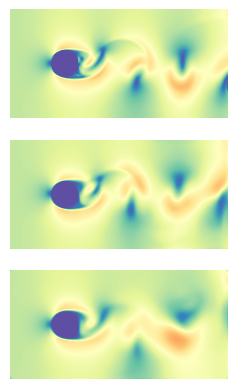

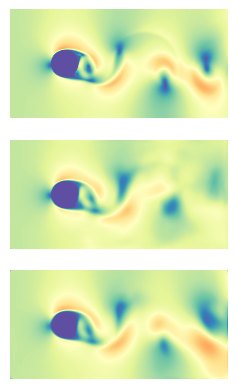

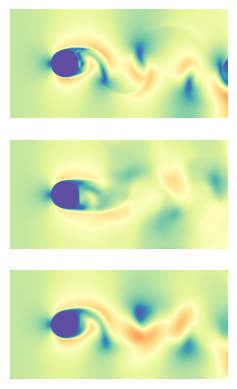

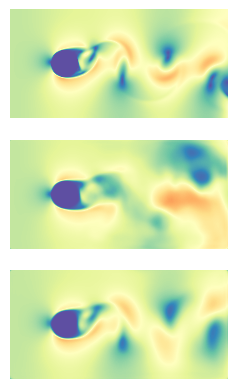

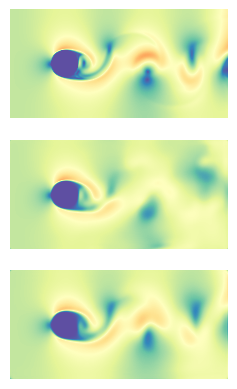

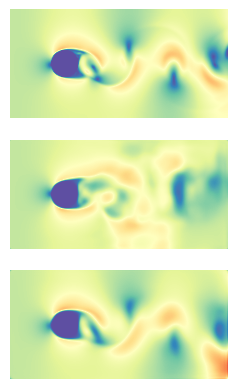

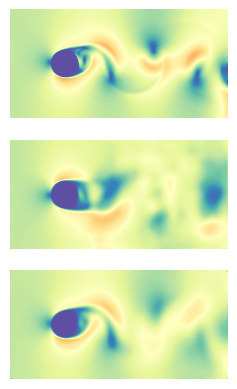

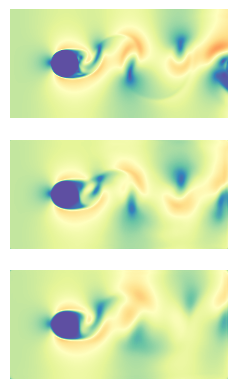

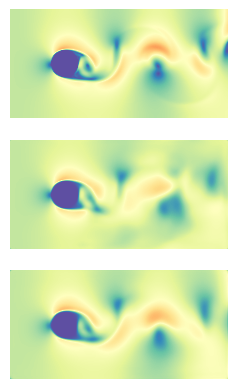

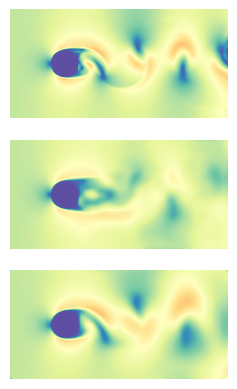

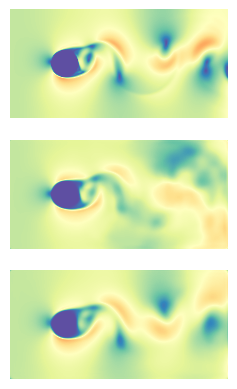

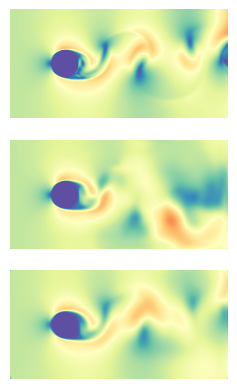

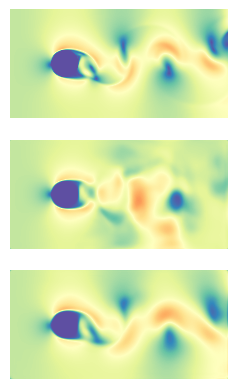

In [16]:
case_id = 3
for i in range(39):
    _, ax = plt.subplots(3,1)
    ax[0].imshow(gt_data[case_id,i,:,:,0], vmin= 0 ,vmax = 1, cmap = 'Spectral_r')
    ax[0].axis("off")
    ax[1].imshow(reconstruction_sens[case_id,i,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[1].axis("off")
    ax[2].imshow(reconstruction_mlp_cnn[case_id,i,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[2].axis("off")
    plt.show()